
# Lab: IoT Multi‑Sensor Forecasting with TimeSeriesSplit
**Goal:** ใช้ข้อมูลหลายเซนเซอร์ (multivariate sensors) เพื่อพยากรณ์ค่า output ของระบบ IoT แบบ time‑series (1‑step และ multi‑step) พร้อมตัวอย่าง **expanding / rolling TimeSeriesSplit**, feature engineering แบบ lag/rolling, เปรียบเทียบโมเดล และ (optional) GridSearchCV แบบไม่รั่วข้อมูลเวลา.

**เหมาะกับ:** พลังงาน/สภาพแวดล้อมโรงงาน/อาคารอัจฉริยะ, คาดการณ์โหลดพลังงาน/อุณหภูมิ/การสั่น, ฯลฯ


## 0) Setup

In [1]:

# Core
import numpy as np
import pandas as pd

# Modeling
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Metrics & Viz
import matplotlib.pyplot as plt

RNG = np.random.RandomState(7)

def mae_score(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))



## 1) Simulate IoT Multi‑Sensor Panel Data
เราจำลอง **หลายอุปกรณ์ (device_id)** โดยแต่ละเครื่องมีเซนเซอร์: `temp`, `humidity`, `vibration`, `current`, `voltage` และเราจะพยากรณ์ **พลังงานที่ใช้ (power_next)** 1 ชั่วโมงถัดไปต่ออุปกรณ์

> หมายเหตุ: สำหรับงานจริง ให้แทนที่ส่วนนี้ด้วยการโหลด CSV (ดูหัวข้อ 9)


In [8]:

# Config
N_DEVICES = 5
N_HOURS   = 24*30  # 30 days hourly
dates = pd.date_range('2025-01-01', periods=N_HOURS, freq='h')

rows = []
for dev in range(N_DEVICES):
    # base profiles per device
    temp_base = 24 + RNG.normal(0, 0.4)
    vib_base = 0.6 + 0.1*dev
    volt_base = 220 + RNG.normal(0, 1.0)
    for t, ts in enumerate(dates):
        # diurnal effects
        diurnal = 2*np.sin(2*np.pi*(t % 24)/24)
        temp = temp_base + 5*np.sin(2*np.pi*(t-6)/24) + RNG.normal(0, 0.6)
        humidity = 55 + 10*np.sin(2*np.pi*(t)/24 + 1.2) + RNG.normal(0, 2.0)
        vibration = vib_base + 0.05*np.sin(2*np.pi*(t)/168) + RNG.normal(0, 0.03)
        current = 4 + 0.8*np.sin(2*np.pi*(t)/24) + 0.02*temp + RNG.normal(0, 0.2)
        voltage = volt_base + 1.5*np.sin(2*np.pi*(t)/24 + 0.5) + RNG.normal(0, 0.8)
        power = voltage*current/100.0 + 0.3*vibration + 0.02*(humidity-50) + 0.1*diurnal + RNG.normal(0, 0.3)
        # next-hour target (shifted later in featurization; here we store current power)
        rows.append([ts, f"dev_{dev:02d}", temp, humidity, vibration, current, voltage, power])

df_raw = pd.DataFrame(rows, columns=['timestamp','device_id','temp','humidity','vibration','current','voltage','power'])
df_raw = df_raw.set_index('timestamp').sort_index()
df_raw.head()


,device_id,temp,humidity,vibration,current,voltage,power
timestamp,,,,,,,
2025-01-01,dev_00,18.282679,68.134582,0.568403,4.874608,221.494849,11.468242
2025-01-01,dev_02,19.270455,59.400908,0.800929,4.198419,221.263901,9.818234
2025-01-01,dev_04,18.646159,67.417132,1.009341,4.237176,221.521803,10.302210
2025-01-01,dev_01,19.370034,67.797509,0.679191,4.549318,222.480972,10.918370
2025-01-01,dev_03,18.753725,66.876119,0.914668,4.177337,221.203643,9.891604



## 2) Feature Engineering — Per‑Device Lags & Rolling
เราจะสร้างฟีเจอร์จาก `power` และเซนเซอร์ทุกตัวแบบ **lag** และ **rolling** ต่ออุปกรณ์ (panel‑aware). Target คือ `power_next` (1‑step ahead).


In [3]:

SENSOR_COLS = ['temp','humidity','vibration','current','voltage','power']

def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    # cyclical encoding (optional)
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['dow_sin']  = np.sin(2*np.pi*df['dayofweek']/7)
    df['dow_cos']  = np.cos(2*np.pi*df['dayofweek']/7)
    return df

def panel_lag_roll(df, group_col='device_id', sensors=SENSOR_COLS, lags=(1,2,3,6,12,24), rolls=(3,6,12,24)):
    df = df.copy()
    df = add_time_features(df)
    # generate next-step target per device
    df['power_next'] = df.groupby(group_col)['power'].shift(-1)
    # lags
    for col in sensors:
        for L in lags:
            df[f'{col}_lag{L}'] = df.groupby(group_col)[col].shift(L)
    # rolling means/stds based on lagged past
    for col in sensors:
        for W in rolls:
            df[f'{col}_rmean{W}'] = df.groupby(group_col)[col].shift(1).rolling(W).mean()
            df[f'{col}_rstd{W}']  = df.groupby(group_col)[col].shift(1).rolling(W).std()
    df = df.dropna().copy()
    return df

df_feat = panel_lag_roll(df_raw)
df_feat.head()


,device_id,temp,humidity,vibration,current,voltage,power,hour,dayofweek,hour_sin,...,voltage_rmean24,voltage_rstd24,power_rmean3,power_rstd3,power_rmean6,power_rstd6,power_rmean12,power_rstd12,power_rmean24,power_rstd24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-02,dev_00,19.512181,62.673471,0.630658,4.083023,220.264792,8.898035,0,3,0.0,...,218.806357,1.524297,9.163497,0.832708,9.013843,0.740150,8.834581,0.568444,8.709856,0.575622
2025-01-02,dev_04,19.407638,63.920605,1.066920,4.283930,221.808656,10.185964,0,3,0.0,...,218.872193,1.601053,9.394016,0.615160,8.958098,0.707779,8.862063,0.576605,8.745242,0.576704
2025-01-02,dev_02,18.889332,65.426770,0.862365,3.901766,220.550302,8.829731,0,3,0.0,...,219.050848,1.475593,9.045630,0.123041,9.133134,0.529181,8.922167,0.552457,8.775358,0.572500
2025-01-02,dev_01,18.748761,65.683507,0.735815,4.519137,217.437682,10.296476,0,3,0.0,...,219.056121,1.471693,9.164730,0.117791,9.164114,0.531894,9.001971,0.526541,8.846721,0.519717
2025-01-02,dev_03,19.451986,62.491533,0.961019,4.196043,220.879758,9.964823,0,3,0.0,...,219.198838,1.542974,9.188352,0.125921,9.291184,0.412796,9.055244,0.514447,8.872510,0.523372



## 3) Prepare X, y
- เราจะพยากรณ์ `power_next` โดยใช้ฟีเจอร์ทั้งหมด (รวม time features)
- **หมายเหตุ panel:** ในตัวอย่างนี้เรา train pooled model ข้ามอุปกรณ์ แต่ยังคง **TimeSeriesSplit ตามเวลาโดยรวม** (ไม่ shuffle)


In [4]:

TARGET = 'power_next'
Y = df_feat[TARGET].copy()
feature_cols = [c for c in df_feat.columns if c not in ['power_next']]
X = df_feat[feature_cols].copy()

X.shape, Y.shape


((3475, 97), (3475,))


## 4) Visualize TimeSeriesSplit (Expanding vs Rolling)


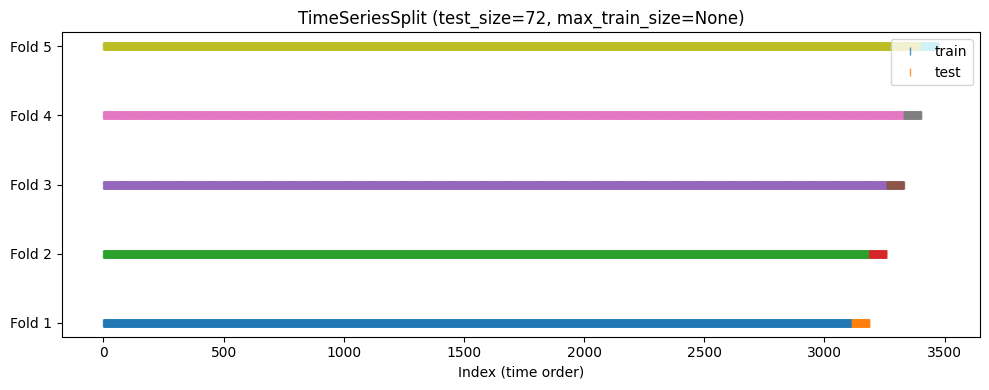

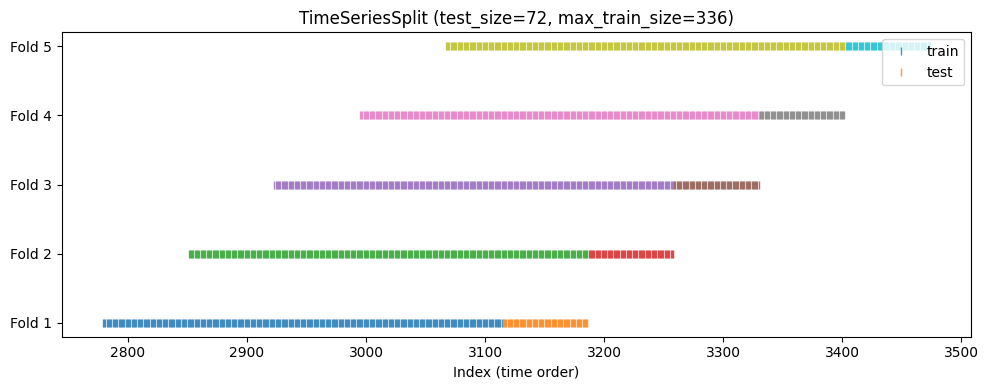

In [5]:

def show_tscv_indices(n_splits=5, test_size=24*3, max_train_size=None):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, max_train_size=max_train_size)
    n = len(X)
    fig, ax = plt.subplots(figsize=(10, 2 + 0.4*n_splits))
    for i, (tr, te) in enumerate(tscv.split(np.arange(n)), 1):
        ax.plot(tr, [i]*len(tr), marker='|', linestyle='None', label='train' if i==1 else "", alpha=0.8)
        ax.plot(te, [i]*len(te), marker='|', linestyle='None', label='test' if i==1 else "", alpha=0.8)
    ax.set_yticks(range(1, n_splits+1))
    ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits+1)])
    ax.set_xlabel('Index (time order)'); ax.legend(loc='upper right')
    ax.set_title(f'TimeSeriesSplit (test_size={test_size}, max_train_size={max_train_size})')
    plt.tight_layout(); plt.show()

# Expanding (train grows)
show_tscv_indices(n_splits=5, test_size=24*3, max_train_size=None)
# Rolling (fixed train window ~ two weeks)
show_tscv_indices(n_splits=5, test_size=24*3, max_train_size=24*14)



## 5) Train Baselines (Ridge vs RandomForest) with Expanding TSCV


In [9]:

tscv = TimeSeriesSplit(n_splits=5, test_size=24*3)

models = {
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0, random_state=7))]),
    'RF': RandomForestRegressor(n_estimators=400, random_state=7, n_jobs=-1)
}

scores = []
for name, mdl in models.items():
    fold_mae, fold_rmse = [], []
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        mdl.fit(Xtr, Ytr)
        yhat = mdl.predict(Xte)
        fold_mae.append(mae_score(Yte, yhat))
        fold_rmse.append(rmse_score(Yte, yhat))
    scores.append({'model': name, 'MAE_mean': np.mean(fold_mae), 'RMSE_mean': np.mean(fold_rmse)})

scores_df = pd.DataFrame(scores).set_index('model')
ax = scores_df[['MAE_mean','RMSE_mean']].plot(kind='bar', figsize=(6,4))
ax.set_title('Mean MAE / RMSE by Model (Expanding TSCV)')
ax.set_ylabel('Error'); ax.set_xlabel('Model')
plt.tight_layout(); plt.show()

scores_df


ValueError: could not convert string to float: 'dev_00'


## 6) Plot Predictions vs Ground Truth (Last Fold, per Device)


In [ ]:

# pick the better model from previous cell for visualization
best_name = scores_df['RMSE_mean'].idxmin()
best_model = models[best_name]

# refit iteratively and capture last fold predictions
for i, (tr, te) in enumerate(tscv.split(X), 1):
    pass
for i, (tr, te) in enumerate(tscv.split(X), 1):
    last_tr, last_te = tr, te

best_model.fit(X.iloc[last_tr], Y.iloc[last_tr])
yhat_last = best_model.predict(X.iloc[last_te])

vis_df = pd.DataFrame({'y_true': Y.iloc[last_te].values, 'y_pred': yhat_last},
                      index=Y.iloc[last_te].index)
vis_df['device_id'] = df_feat.iloc[last_te]['device_id'].values

# Plot a couple of devices
for dev in vis_df['device_id'].unique()[:3]:
    sub = vis_df[vis_df['device_id']==dev][['y_true','y_pred']]
    ax = sub.plot(figsize=(10,3))
    ax.set_title(f'Last Fold – {best_name} – {dev}')
    ax.set_ylabel('power_next')
    plt.tight_layout(); plt.show()



## 7) Multi‑Step Forecasting (H‑step)
เราจะสร้างเมทริกซ์ target หลายคอลัมน์: `power_lead1..power_leadH` และลองสองวิธี:
- **Direct**: โมเดลแยกสำหรับแต่ละ horizon
- **MultiOutput**: โมเดลเดียวพยากรณ์เวกเตอร์หลายค่าสุดท้าย


In [ ]:

def build_panel_supervised(df, H=6, group_col='device_id'):
    df = df.copy()
    # ensure we already have lags/rolls from df_feat
    for h in range(1, H+1):
        df[f'power_lead{h}'] = df.groupby(group_col)['power'].shift(-h)
    df2 = df.dropna().copy()
    feature_cols = [c for c in df2.columns if not c.startswith('power_lead') and c != 'power_next']
    XH = df2[feature_cols]
    YH = df2[[f'power_lead{h}' for h in range(1, H+1)]]
    return XH, YH

H = 6
XH, YH = build_panel_supervised(df_feat, H=H)
XH.shape, YH.shape


In [ ]:

# 7.1 Direct strategy (Ridge base)
def tscv_direct(X, Y, base_estimator, tscv):
    H = Y.shape[1]
    mae_h, rmse_h = [[] for _ in range(H)], [[] for _ in range(H)]
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        preds = np.zeros_like(Yte.values, dtype=float)
        for h in range(H):
            pipe = Pipeline([('scaler', StandardScaler()), ('model', base_estimator)])
            pipe.fit(Xtr, Ytr.iloc[:,h])
            preds[:,h] = pipe.predict(Xte)
        for h in range(H):
            mae_h[h].append(mae_score(Yte.iloc[:,h], preds[:,h]))
            rmse_h[h].append(rmse_score(Yte.iloc[:,h], preds[:,h]))
    return [np.mean(m) for m in mae_h], [np.mean(m) for m in rmse_h]

tscv_H = TimeSeriesSplit(n_splits=5, test_size=24*3)
mae_dir, rmse_dir = tscv_direct(XH, YH, Ridge(random_state=7), tscv_H)
pd.DataFrame({'h': np.arange(1, H+1), 'MAE': mae_dir, 'RMSE': rmse_dir})


In [ ]:

# 7.2 MultiOutput strategy (RF inside MultiOutputRegressor)
def tscv_multioutput(X, Y, base_estimator, tscv):
    H = Y.shape[1]
    mae_h, rmse_h = [[] for _ in range(H)], [[] for _ in range(H)]
    model = Pipeline([('scaler', StandardScaler()), ('mo', MultiOutputRegressor(base_estimator))])
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        model.fit(Xtr, Ytr)
        preds = model.predict(Xte)
        for h in range(H):
            mae_h[h].append(mae_score(Yte.iloc[:,h], preds[:,h]))
            rmse_h[h].append(rmse_score(Yte.iloc[:,h], preds[:,h]))
    return [np.mean(m) for m in mae_h], [np.mean(m) for m in rmse_h]

mae_mo, rmse_mo = tscv_multioutput(XH, YH, RandomForestRegressor(n_estimators=300, random_state=7, n_jobs=-1), tscv_H)
pd.DataFrame({'h': np.arange(1, H+1), 'MAE': mae_mo, 'RMSE': rmse_mo})


In [ ]:

# Compare MAE & RMSE by horizon
cmp = pd.DataFrame({
    'h': np.arange(1, H+1),
    'Direct_MAE': mae_dir, 'MultiOut_MAE': mae_mo,
    'Direct_RMSE': rmse_dir, 'MultiOut_RMSE': rmse_mo
}).set_index('h')

ax = cmp[['Direct_MAE','MultiOut_MAE']].plot(figsize=(8,4))
ax.set_title('MAE by Horizon'); ax.set_xlabel('Horizon (hours)'); ax.set_ylabel('MAE')
plt.tight_layout(); plt.show()

ax = cmp[['Direct_RMSE','MultiOut_RMSE']].plot(figsize=(8,4))
ax.set_title('RMSE by Horizon'); ax.set_xlabel('Horizon (hours)'); ax.set_ylabel('RMSE')
plt.tight_layout(); plt.show()

cmp



## 8) (Optional) Nested GridSearchCV (No Temporal Leakage)
จูนเฉพาะบน **train** ของแต่ละ outer fold ด้วย **inner TimeSeriesSplit**


In [ ]:

outer = TimeSeriesSplit(n_splits=4, test_size=24*3)
inner = TimeSeriesSplit(n_splits=3, test_size=24)

ridge_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=7))])
ridge_grid = {'model__alpha': [0.1, 0.3, 1.0, 3.0, 10.0]}

outer_res = []
for i, (tr, te) in enumerate(outer.split(X), 1):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    Ytr, Yte = Y.iloc[tr], Y.iloc[te]
    gs = GridSearchCV(ridge_pipe, ridge_grid, scoring='neg_root_mean_squared_error', cv=inner, n_jobs=-1, return_train_score=True)
    gs.fit(Xtr, Ytr)
    yhat = gs.best_estimator_.predict(Xte)
    outer_res.append({'fold': i, 'alpha': gs.best_params_['model__alpha'], 'MAE': mae_score(Yte,yhat), 'RMSE': rmse_score(Yte,yhat)})

pd.DataFrame(outer_res)



## 9) (Optional) ใช้ **CSV จริงของคุณ**
- ต้องมีคอลัมน์ `timestamp`, `device_id`, sensor ต่าง ๆ และ `power` (หรือเปลี่ยนชื่อ target ด้านล่าง)
- ตั้งค่าแล้วรัน cell เหล่านี้ เพื่อแทนที่ `df_raw`


In [ ]:

USE_REAL = False
CSV_PATH = "iot_sensors.csv"
TIMECOL  = "timestamp"
DEVICECOL= "device_id"
TARGET_POWER_COL = "power"    # เปลี่ยนชื่อ target ได้

if USE_REAL:
    df_real = pd.read_csv(CSV_PATH)
    df_real[TIMECOL] = pd.to_datetime(df_real[TIMECOL], errors='coerce')
    df_real = df_real.dropna(subset=[TIMECOL, DEVICECOL, TARGET_POWER_COL]).set_index(TIMECOL).sort_index()
    # ตรวจชื่อคอลัมน์ฯลฯ แล้วดำเนินการเหมือนส่วนด้านบน:
    df_raw = df_real.rename(columns={TARGET_POWER_COL:'power'})
    # Rebuild features
    df_feat = panel_lag_roll(df_raw)
    TARGET = 'power_next'
    Y = df_feat[TARGET].copy()
    feature_cols = [c for c in df_feat.columns if c not in ['power_next']]
    X = df_feat[feature_cols].copy()
    print("Loaded real CSV. Shapes:", X.shape, Y.shape)
else:
    print("Using simulated data. Set USE_REAL=True to switch.")



## 10) Deployment Notes (IoT Edge/Cloud)
- **Edge preprocessing:** สร้าง lag/rolling บนอุปกรณ์หรือเก็บ buffer ของค่าล่าสุดเพียงไม่กี่จุดเพื่อคำนวณฟีเจอร์
- **Concept drift:** ใช้ **rolling window** หรือ **partial refit** ตามรอบเวลาที่เหมาะสม
- **Missing data:** เติมค่าขาดด้วยวิธี domain‑aware (เช่น forward‑fill จำกัดช่วง, model‑based imputation)
- **Known future exogenous:** ถ้ามีตารางการผลิต/กำหนดโหลด/ตารางเครื่องปรับอากาศล่วงหน้า ให้ใส่เป็น **known future features** ตอน inference เพื่อแม่นยำขึ้น
- **Monitoring:** ติดตาม MAE/RMSE แบบ online และตั้ง threshold แจ้งเตือน
